In [1]:
# importing the libraries

In [40]:
import tensorflow as tf
import random
from tensorflow.keras.datasets import fashion_mnist
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_circles
from sklearn.metrics import confusion_matrix

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Multi-Class Classification

We've seen a binary classification example (predicting if a data point is part of a red circle or blue circle) but what if you had multiple different classes of things?

For example, say you were a fashion company and you wanted to build a neural network to predict whether a piece of clothing was a shoe, a shirt or a jacket (3 different options).

When you have more than two classes as an option, this is known as multiclass classification.

The good news is, the things we've learned so far (with a few tweaks) can be applied to multiclass classification problems as well.

Let's see it in action.

To start, we'll need some data. The good thing for us is TensorFlow has a multiclass classication dataset known as Fashion MNIST built-in. Meaning we can get started straight away.

We can import it using the tf.keras.datasets module.

The following multiclass classification problem has been adapted from the TensorFlow classification guide. A good exercise would be to once you've gone through the following example, replicate the TensorFlow guide.

https://www.tensorflow.org/tutorials/keras/classification

In [4]:
# The data has already been sorted into training and test sets for us
(train_data, train_labels), (test_data, test_labels) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [5]:
# Show the first training example
print(f"Training sample:\n{train_data[0]}\n") 
print(f"Training label: {train_labels[0]}")

Training sample:
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   1   0   0  13  73   0
    0   1   4   0   0   0   0   1   1   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3   0  36 136 127  62
   54   0   0   0   1   3   4   0   0   3]
 [  0   0   0   0   0   0   0   0   0   0   0   0   6   0 102 204 176 134
  144 123  23   0   0   0   0  12  10   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 155 236 207 178
  107 156 161 109  64  23  77 130  72  15]
 [  0   0   0   0   0   0   0   0   0   0   0   1   0  69 207 223 218 216
  216 163 127 121 122 146 141  88 172  66]
 [  0   0   0   0   0   0   0   0   0   1   1  

In [6]:
# Check the shape of our data
train_data.shape, train_labels.shape, test_data.shape, test_labels.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [7]:
# Check shape of a single example
train_data[0].shape, train_labels[0].shape

((28, 28), ())

Okay, 60,000 training examples each with shape (28, 28) and a label each as well as 10,000 test examples of shape (28, 28).

But these are just numbers, let's visualize.


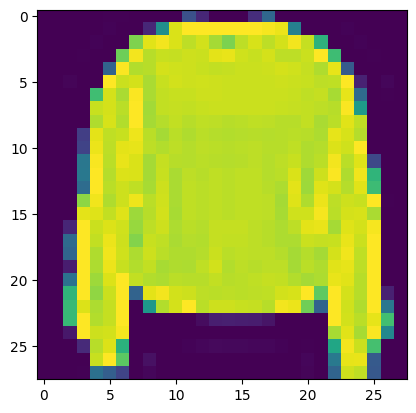

In [8]:
# Plot a single example
import matplotlib.pyplot as plt
plt.imshow(train_data[7]);

Hmm, but what about its label?

In [9]:
# Check our samples label
train_labels[7]

2


It looks like our labels are in numerical form. And while this is fine for a neural network, you might want to have them in human readable form.

Let's create a small list of the class names (we can find them on the dataset's GitHub page).

https://github.com/zalandoresearch/fashion-mnist#labels

🔑 Note: Whilst this dataset has been prepared for us and ready to go, it's important to remember many datasets won't be ready to go like this one. Often you'll have to do a few preprocessing steps to have it ready to use with a neural network (we'll see more of this when we work with our own data later).

In [10]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# How many classes are there (this'll be our output shape)?
len(class_names)

10



Now we have these, let's plot another example.

🤔 Question: Pay particular attention to what the data we're working with looks like. Is it only straight lines? Or does it have non-straight lines as well? Do you think if we wanted to find patterns in the photos of clothes (which are actually collections of pixels), will our model need non-linearities (non-straight lines) or not?



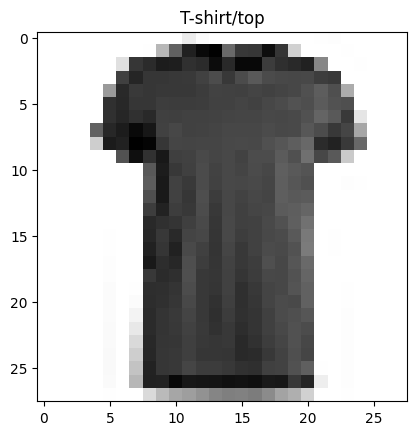

In [11]:
# Plot an example image and its label
# cm means color map
plt.imshow(train_data[17], cmap=plt.cm.binary) # change the colours to black & white
plt.title(class_names[train_labels[17]]);

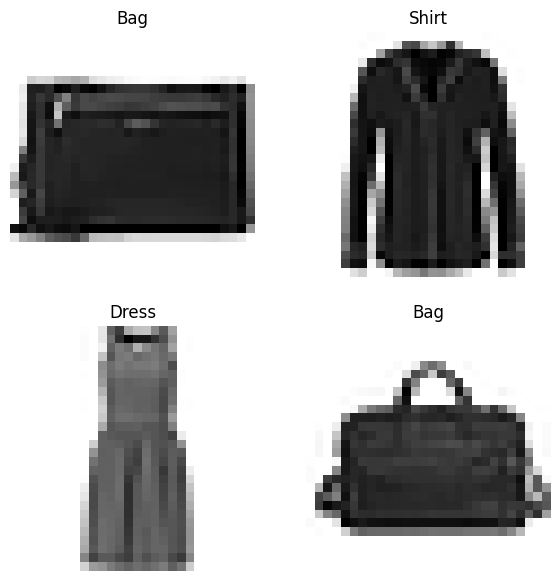

In [12]:
# Plot multiple random images of fashion MNIST
import random
plt.figure(figsize=(7, 7))
for i in range(4):
  ax = plt.subplot(2, 2, i + 1)
  rand_index = random.choice(range(len(train_data)))
  plt.imshow(train_data[rand_index], cmap=plt.cm.binary)
  plt.title(class_names[train_labels[rand_index]])
  plt.axis(False)

Alright, let's build a model to figure out the relationship between the pixel values and their labels.

Since this is a multiclass classification problem, we'll need to make a few changes to our architecture (inline with Table 1 above):

The input shape will have to deal with 28x28 tensors (the height and width of our images).

We're actually going to squash the input into a tensor (vector) of shape (784).

The output shape will have to be 10 because we need our model to predict for 10 different classes.

We'll also change the activation parameter of our output layer to be "softmax" instead of 'sigmoid'. As we'll see the "softmax" activation function outputs a series of values between 0 & 1 (the same shape as output shape, which together add up to ~1. The index with the highest value is predicted by the model to be the most likely class.

We'll need to change our loss function from a binary loss function to a multiclass loss function.

More specifically, since our labels are in integer form, we'll use tf.keras.losses.

SparseCategoricalCrossentropy(), if our labels were one-hot encoded (e.g. they looked something like [0, 0, 1, 0, 0...]), we'd use tf.keras.losses.CategoricalCrossentropy().

We'll also use the validation_data parameter when calling the fit() function. This will give us an idea of how the model performs on the test set during training.


In [13]:
# Set random seed
tf.random.set_seed(42)

# Create the model
model_11 = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)), # input layer (we had to reshape 28x28 to 784, the Flatten layer does this for us)
  tf.keras.layers.Dense(4, activation="relu"),
  tf.keras.layers.Dense(4, activation="relu"),
  tf.keras.layers.Dense(10, activation="softmax") # output shape is 10, activation is softmax
])

# Compile the model
model_11.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), # different loss function for multiclass classifcation
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=["accuracy"])

# Fit the model
non_norm_history = model_11.fit(train_data,
                                train_labels,
                                epochs=100,
                                validation_data=(test_data, test_labels)) # see how the model performs on the test set during training

Epoch 1/100
1875/1875 [==============================] - 7s 3ms/step - loss: 2.4610 - accuracy: 0.0984 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 2/100
1875/1875 [==============================] - 4s 2ms/step - loss: 2.3028 - accuracy: 0.0985 - val_loss: 2.3027 - val_accuracy: 0.1000
Epoch 3/100
1875/1875 [==============================] - 5s 3ms/step - loss: 2.3027 - accuracy: 0.1002 - val_loss: 2.3027 - val_accuracy: 0.1000
Epoch 4/100
1875/1875 [==============================] - 6s 3ms/step - loss: 2.3028 - accuracy: 0.0975 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 5/100
1875/1875 [==============================] - 4s 2ms/step - loss: 2.3028 - accuracy: 0.0973 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 6/100
1875/1875 [==============================] - 5s 3ms/step - loss: 2.3028 - accuracy: 0.0992 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 7/100
1875/1875 [==============================] - 7s 4ms/step - loss: 2.3028 - accuracy: 0.0987 - val_loss: 2.3026 - val_ac

In [14]:
# Check the shapes of our model
# Note: the "None" in (None, 784) is for batch_size, we'll cover this in a later module
model_11.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 4)                 3140      
                                                                 
 dense_1 (Dense)             (None, 4)                 20        
                                                                 
 dense_2 (Dense)             (None, 10)                50        
                                                                 
Total params: 3,210
Trainable params: 3,210
Non-trainable params: 0
_________________________________________________________________


Alright, our model gets to about ~35% accuracy after 10 epochs using a similar style model to what we used on our binary classification problem.

Which is better than guessing (guessing with 10 classes would result in about 10% accuracy) but we can do better.

Do you remember when we talked about neural networks preferring numbers between 0 and 1? (if not, treat this as a reminder)

Well, right now, the data we have isn't between 0 and 1, in other words, it's not normalized (hence why we used the non_norm_history variable when calling fit()). It's pixel values are between 0 and 255.

In [15]:
# Check the min and max values of the training data
train_data.min(), train_data.max()

(0, 255)

We can get these values between 0 and 1 by dividing the entire array by the maximum: 255.0 (dividing by a float also converts to a float).

Doing so will result in all of our data being between 0 and 1 (known as scaling or normalization).

In [16]:
# Divide train and test images by the maximum value (normalize it)
train_data = train_data / 255.0
test_data = test_data / 255.0

# Check the min and max values of the training data
train_data.min(), train_data.max()

(0.0, 1.0)

Now our data is between 0 and 1. Let's see what happens when we model it.

We'll use the same model as before (model_11) except this time the data will be normalized.

In [17]:
# Set random seed
tf.random.set_seed(42)

# Create the model
model_12 = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)), # input layer (we had to reshape 28x28 to 784)
  tf.keras.layers.Dense(4, activation="relu"),
  tf.keras.layers.Dense(4, activation="relu"),
  tf.keras.layers.Dense(10, activation="softmax") # output shape is 10, activation is softmax
])

# Compile the model
model_12.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=["accuracy"])

# Fit the model (to the normalized data)
norm_history = model_12.fit(train_data,
                            train_labels,
                            epochs=100,
                            validation_data=(test_data, test_labels))

Epoch 1/100
1875/1875 [==============================] - 7s 3ms/step - loss: 1.0200 - accuracy: 0.6199 - val_loss: 0.6431 - val_accuracy: 0.7831
Epoch 2/100
1875/1875 [==============================] - 5s 3ms/step - loss: 0.5930 - accuracy: 0.7980 - val_loss: 0.6271 - val_accuracy: 0.7948
Epoch 3/100
1875/1875 [==============================] - 4s 2ms/step - loss: 0.5496 - accuracy: 0.8130 - val_loss: 0.5736 - val_accuracy: 0.7992
Epoch 4/100
1875/1875 [==============================] - 6s 3ms/step - loss: 0.5303 - accuracy: 0.8191 - val_loss: 0.5653 - val_accuracy: 0.8047
Epoch 5/100
1875/1875 [==============================] - 5s 3ms/step - loss: 0.5197 - accuracy: 0.8224 - val_loss: 0.5544 - val_accuracy: 0.8101
Epoch 6/100
1875/1875 [==============================] - 4s 2ms/step - loss: 0.5107 - accuracy: 0.8243 - val_loss: 0.5616 - val_accuracy: 0.8089
Epoch 7/100
1875/1875 [==============================] - 5s 2ms/step - loss: 0.5061 - accuracy: 0.8262 - val_loss: 0.5480 - val_ac

Let's plot each model's history (their loss curves).

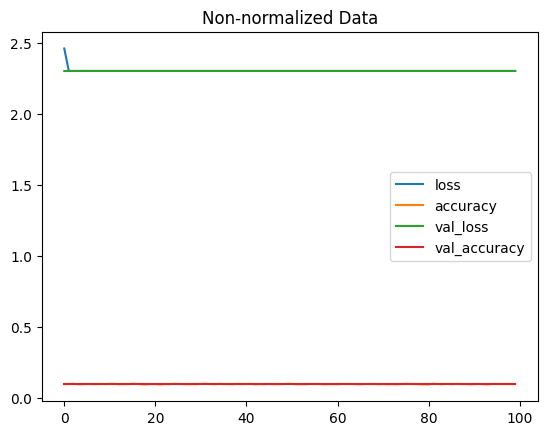

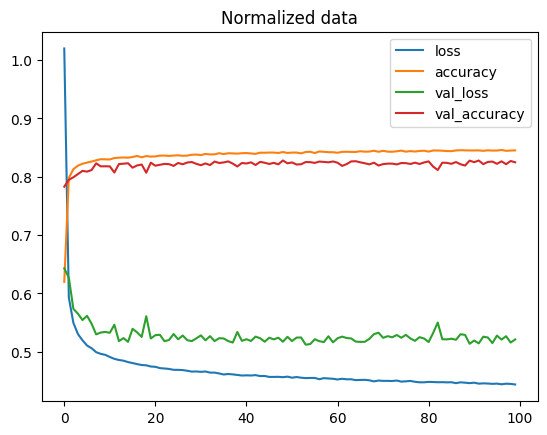

In [18]:
# Plot non-normalized data loss curves
pd.DataFrame(non_norm_history.history).plot(title="Non-normalized Data")
# Plot normalized data loss curves
pd.DataFrame(norm_history.history).plot(title="Normalized data");

Wow. From these two plots, we can see how much quicker our model with the normalized data (model_12) improved than the model with the non-normalized data (model_11).

🔑 Note: The same model with even slightly different data can produce dramatically different results. So when you're comparing models, it's important to make sure you're comparing them on the same criteria (e.g. same architecture but different data or same data but different architecture).

How about we find the ideal learning rate and see what happens?

We'll use the same architecture we've been using.


In [19]:
# Set random seed
tf.random.set_seed(42)

# Create the model
model_13 = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)), # input layer (we had to reshape 28x28 to 784)
  tf.keras.layers.Dense(4, activation="relu"),
  tf.keras.layers.Dense(4, activation="relu"),
  tf.keras.layers.Dense(10, activation="softmax") # output shape is 10, activation is softmax
])

# Compile the model
model_13.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=["accuracy"])

# Create the learning rate callback
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3 * 10**(epoch/20))

# Fit the model
find_lr_history = model_13.fit(train_data,
                               train_labels,
                               epochs=40, # model already doing pretty good with current LR, probably don't need 100 epochs
                               validation_data=(test_data, test_labels),
                               callbacks=[lr_scheduler])

Epoch 1/40
1875/1875 [==============================] - 5s 2ms/step - loss: 1.2664 - accuracy: 0.5206 - val_loss: 0.9106 - val_accuracy: 0.6514 - lr: 0.0010
Epoch 2/40
1875/1875 [==============================] - 6s 3ms/step - loss: 0.8275 - accuracy: 0.6782 - val_loss: 0.7876 - val_accuracy: 0.7025 - lr: 0.0011
Epoch 3/40
1875/1875 [==============================] - 5s 3ms/step - loss: 0.7433 - accuracy: 0.7175 - val_loss: 0.7328 - val_accuracy: 0.7321 - lr: 0.0013
Epoch 4/40
1875/1875 [==============================] - 4s 2ms/step - loss: 0.6838 - accuracy: 0.7499 - val_loss: 0.6850 - val_accuracy: 0.7578 - lr: 0.0014
Epoch 5/40
1875/1875 [==============================] - 5s 3ms/step - loss: 0.6501 - accuracy: 0.7689 - val_loss: 0.6486 - val_accuracy: 0.7775 - lr: 0.0016
Epoch 6/40
1875/1875 [==============================] - 6s 3ms/step - loss: 0.6218 - accuracy: 0.7847 - val_loss: 0.6626 - val_accuracy: 0.7716 - lr: 0.0018
Epoch 7/40
1875/1875 [==============================] - 4s

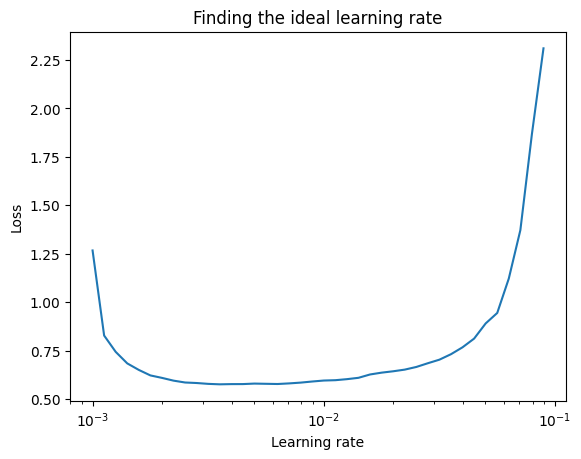

In [20]:
# Plot the learning rate decay curve
import numpy as np
import matplotlib.pyplot as plt
lrs = 1e-3 * (10**(np.arange(40)/20))
plt.semilogx(lrs, find_lr_history.history["loss"]) # want the x-axis to be log-scale
plt.xlabel("Learning rate")
plt.ylabel("Loss")
plt.title("Finding the ideal learning rate");

In this case, it looks like somewhere close to the default learning rate of the Adam optimizer (0.001) is the ideal learning rate.

Let's refit a model using the ideal learning rate.

In [21]:
# Set random seed
tf.random.set_seed(42)

# Create the model
model_14 = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)), # input layer (we had to reshape 28x28 to 784)
  tf.keras.layers.Dense(4, activation="relu"),
  tf.keras.layers.Dense(4, activation="relu"),
  tf.keras.layers.Dense(10, activation="softmax") # output shape is 10, activation is softmax
])

# Compile the model
model_14.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                 optimizer=tf.keras.optimizers.Adam(lr=0.001), # ideal learning rate (same as default)
                 metrics=["accuracy"])

# Fit the model
history = model_14.fit(train_data,
                       train_labels,
                       epochs=20,
                       validation_data=(test_data, test_labels))

Epoch 1/20
1875/1875 [==============================] - 6s 3ms/step - loss: 1.2721 - accuracy: 0.5116 - val_loss: 1.0007 - val_accuracy: 0.6187
Epoch 2/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.8111 - accuracy: 0.7320 - val_loss: 0.7170 - val_accuracy: 0.7735
Epoch 3/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.6496 - accuracy: 0.7973 - val_loss: 0.6476 - val_accuracy: 0.7915
Epoch 4/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.5992 - accuracy: 0.8064 - val_loss: 0.6218 - val_accuracy: 0.7985
Epoch 5/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.5716 - accuracy: 0.8102 - val_loss: 0.6150 - val_accuracy: 0.7959
Epoch 6/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.5549 - accuracy: 0.8125 - val_loss: 0.6127 - val_accuracy: 0.7937
Epoch 7/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.5470 - accuracy: 0.8141 - val_loss: 0.6082 - val_accuracy:

Now we've got a model trained with a close-to-ideal learning rate and performing pretty well, we've got a couple of options.

We could:

Evaluate its performance using other classification metrics (such as a confusion matrix or classification report).

Assess some of its predictions (through visualizations).

Improve its accuracy (by training it for longer or changing the architecture).

Save and export it for use in an application.

Let's go through the first two options.

First we'll create a classification matrix to visualize its predictions across the different classes.


In [25]:
# Note: The following confusion matrix code is a remix of Scikit-Learn's 
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
# and Made with ML's introductory notebook - https://github.com/GokuMohandas/MadeWithML/blob/main/notebooks/08_Neural_Networks.ipynb
import itertools
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
             horizontalalignment="center",
             color="white" if cm[i, j] > threshold else "black",
             size=text_size)

Our model outputs a list of prediction probabilities, meaning, it outputs a number for how likely it thinks a particular class is to be the label.

The higher the number in the prediction probabilities list, the more likely the model believes that is the right class.

To find the highest value we can use the argmax() method.

Since a confusion matrix compares the truth labels (test_labels) to the predicted labels, we have to make some predictions with our model.


In [27]:
# Make predictions with the most recent model
y_probs = model_14.predict(test_data) # "probs" is short for probabilities

# View the first 5 predictions
y_probs[:5]

313/313 [==============================] - 2s 4ms/step


array([[3.54786884e-08, 1.49247777e-15, 6.48594789e-11, 9.59647119e-12,
        4.76678946e-31, 5.43384433e-01, 1.41546309e-07, 6.33199438e-02,
        4.16118215e-04, 3.92879307e-01],
       [1.09181536e-04, 1.15596927e-17, 9.43954408e-01, 1.50937733e-04,
        1.02264266e-02, 5.61787758e-13, 4.55571264e-02, 5.19918255e-26,
        1.86616205e-06, 2.13496786e-20],
       [2.84475298e-03, 9.79598582e-01, 2.33232990e-04, 1.41986450e-02,
        4.13867849e-04, 7.45608879e-04, 8.35508807e-04, 1.00634701e-03,
        6.09593226e-05, 6.23393134e-05],
       [2.66594836e-03, 9.81325388e-01, 2.06898956e-04, 1.26797855e-02,
        3.77228367e-04, 7.63263437e-04, 7.79839058e-04, 1.07818365e-03,
        6.02375003e-05, 6.31204166e-05],
       [9.44913030e-02, 1.35815503e-06, 1.75366983e-01, 1.88160148e-02,
        3.40071246e-02, 3.50423834e-05, 6.65501535e-01, 2.23197745e-11,
        1.17806066e-02, 2.56980148e-09]], dtype=float32)

In [28]:
# See the predicted class number and label for the first example
y_probs[0].argmax(), class_names[y_probs[0].argmax()]

(5, 'Sandal')

Now let's do the same for all of the predictions.

In [29]:
# Convert all of the predictions from probabilities to labels
y_preds = y_probs.argmax(axis=1)

# View the first 10 prediction labels
y_preds[:10]

array([5, 2, 1, 1, 6, 1, 4, 6, 5, 7])

In [30]:
# Check out the non-prettified confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true=test_labels, 
                 y_pred=y_preds)

array([[732,  16,  11,  89,   6,   0, 136,   1,   9,   0],
       [  1, 950,   0,  33,   6,   0,   9,   0,   1,   0],
       [ 17,   1, 570,  41, 223,   0, 146,   0,   2,   0],
       [ 31,  24,  13, 853,  35,   1,  42,   0,   1,   0],
       [  1,   3,  59,  41, 824,   0,  72,   0,   0,   0],
       [  1,   1,   0,   1,   0, 893,   0,  47,  24,  33],
       [147,  16,  82,  59, 168,   0, 521,   0,   7,   0],
       [  0,   0,   0,   0,   0,  59,   0, 910,   0,  31],
       [ 12,   2,   5,   2,   6,   7,  62,   4, 900,   0],
       [  1,   0,   0,   0,   0,  36,   0,  48,   1, 914]])

That confusion matrix is hard to comprehend, let's make it prettier using the function we created before.

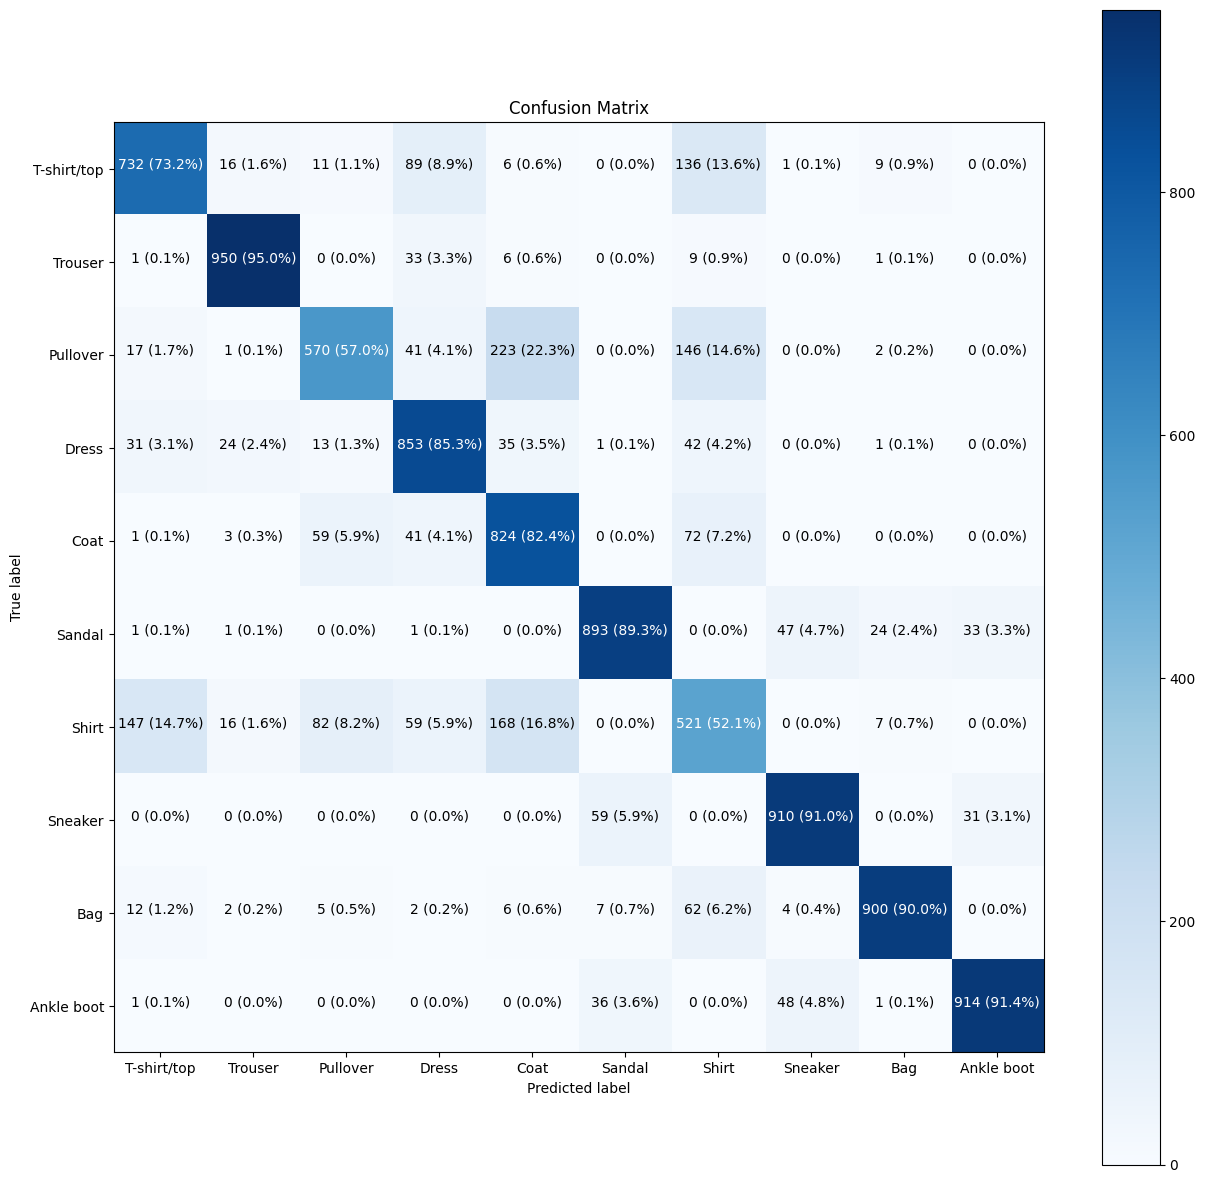

In [31]:
# Make a prettier confusion matrix
make_confusion_matrix(y_true=test_labels, 
                      y_pred=y_preds,
                      classes=class_names,
                      figsize=(15, 15),
                      text_size=10)

It looks like our model is getting confused between the Shirt and T-shirt/top classes (e.g. predicting Shirt when it's actually a T-shirt/top).

🤔 Question: Does it make sense that our model is getting confused between the Shirt and T-shirt/top classes? Why do you think this might be? What's one way you could investigate?

We've seen how our models predictions line up to the truth labels using a confusion matrix, but how about we visualize some?

Let's create a function to plot a random image along with its prediction.

🔑 Note: Often when working with images and other forms of visual data, it's a good idea to visualize as much as possible to develop a further understanding of the data and the outputs of your model.

In [41]:
# Create a function for plotting a random image along with its prediction
def plot_random_image(model, images, true_labels, classes):
  """Picks a random image, plots it and labels it with a predicted and truth label.

  Args:
    model: a trained model (trained on data similar to what's in images).
    images: a set of random images (in tensor form).
    true_labels: array of ground truth labels for images.
    classes: array of class names for images.
  
  Returns:
    A plot of a random image from `images` with a predicted class label from `model`
    as well as the truth class label from `true_labels`.
  """ 
  # Setup random integer
  i = random.randint(0, len(images))
  
  # Create predictions and targets
  target_image = images[i]
  pred_probs = model.predict(target_image.reshape(1, 28, 28)) # have to reshape to get into right size for model
  pred_label = classes[pred_probs.argmax()]
  true_label = classes[true_labels[i]]

  # Plot the target image
  plt.imshow(target_image, cmap=plt.cm.binary)

  # Change the color of the titles depending on if the prediction is right or wrong
  if pred_label == true_label:
    color = "green"
  else:
    color = "red"

  # Add xlabel information (prediction/true label)
  plt.xlabel("Pred: {} {:2.0f}% (True: {})".format(pred_label,
                                                   100*tf.reduce_max(pred_probs),
                                                   true_label),
             color=color) # set the color to green or red

1/1 [==============================] - 0s 35ms/step


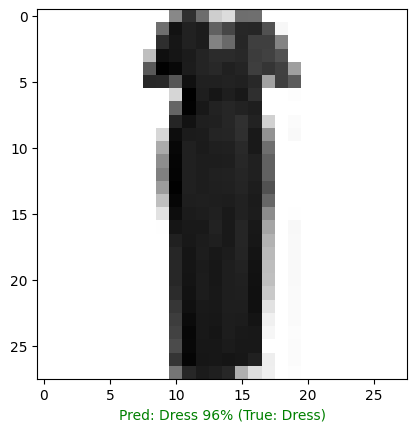

In [42]:
# Check out a random image as well as its prediction
plot_random_image(model=model_14, 
                  images=test_data, 
                  true_labels=test_labels, 
                  classes=class_names)

# What patterns is our model learning?

First, we'll get a list of layers in our most recent model (model_14) using the layers attribute.

In [43]:
# Find the layers of our most recent model
model_14.layers

We can access a target layer using indexing.

In [44]:
# Extract a particular layer
model_14.layers[1]

And we can find the patterns learned by a particular layer using the get_weights() method.

The get_weights() method returns the weights (also known as a weights matrix) and biases (also known as a bias vector) of a particular layer.


In [45]:
# Get the patterns of a layer in our network
weights, biases = model_14.layers[1].get_weights()

# Shape = 1 weight matrix the size of our input data (28x28) per neuron (4)
weights, weights.shape

(array([[ 0.60637933, -0.26708573,  0.24157958, -0.8067531 ],
        [-0.787804  , -0.22974448,  0.745579  , -0.21781136],
        [-0.5783931 , -1.0267841 ,  0.63639194,  0.23651208],
        ...,
        [ 0.12347916,  0.04276521,  0.65418327, -0.27452162],
        [ 0.7176562 ,  0.41057515,  0.25855443, -1.0657079 ],
        [ 0.39262724, -0.36153418,  0.31576648, -0.18423533]],
       dtype=float32),
 (784, 4))

The weights matrix is the same shape as the input data, which in our case is 784 (28x28 pixels). And there's a copy of the weights matrix for each neuron the in the selected layer (our selected layer has 4 neurons).

Each value in the weights matrix corresponds to how a particular value in the input data influences the network's decisions.

These values start out as random numbers (they're set by the kernel_initializer parameter when creating a layer, the default is "glorot_uniform") and are then updated to better representative values of the data (non-random) by the neural network during training.

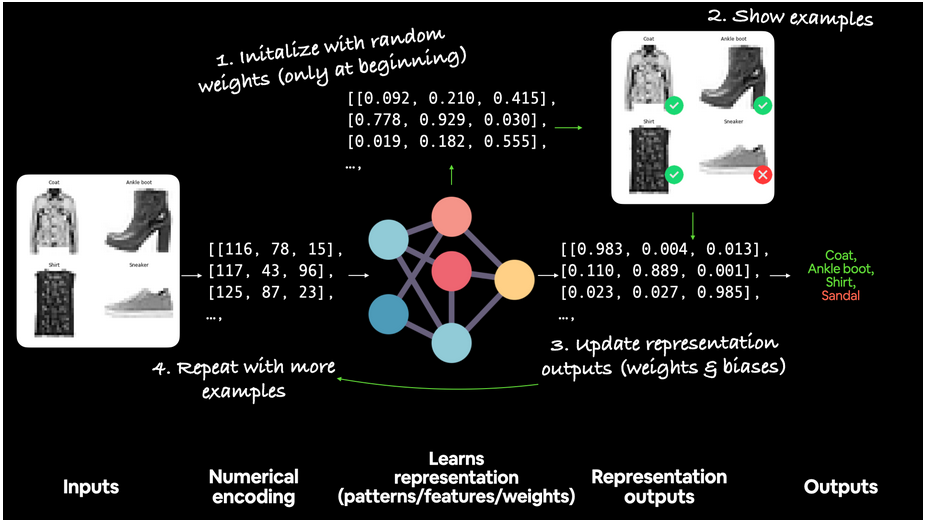

Example workflow of how a supervised neural network starts with random weights and updates them to better represent the data by looking at examples of ideal outputs.

## Now let's check out the bias vector.

In [46]:
# Shape = 1 bias per neuron (we use 4 neurons in the first layer)
biases, biases.shape

(array([ 0.7295249 ,  1.5738864 , -0.25727537,  2.113969  ], dtype=float32),
 (4,))

Every neuron has a bias vector. Each of these is paired with a weight matrix.

The bias values get initialized as zeroes by default (using the bias_initializer parameter).

The bias vector dictates how much the patterns within the corresponding weights matrix should influence the next layer.


In [47]:
# Can now calculate the number of paramters in our model
model_14.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 784)               0         
                                                                 
 dense_9 (Dense)             (None, 4)                 3140      
                                                                 
 dense_10 (Dense)            (None, 4)                 20        
                                                                 
 dense_11 (Dense)            (None, 10)                50        
                                                                 
Total params: 3,210
Trainable params: 3,210
Non-trainable params: 0
_________________________________________________________________


Now we've built a few deep learning models, it's a good time to point out the whole concept of inputs and outputs not only relates to a model as a whole but to every layer within a model.

You might've already guessed this, but starting from the input layer, each subsequent layer's input is the output of the previous layer.

We can see this clearly using the utility plot_model().

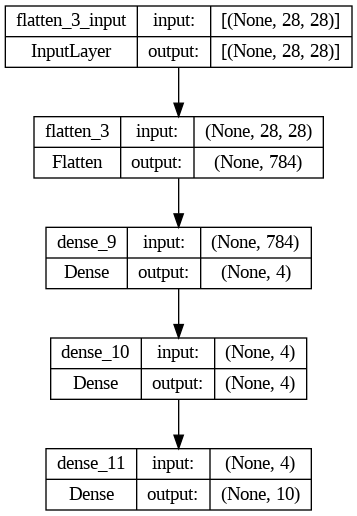

In [48]:
# See the inputs and outputs of each layer
plot_model(model_14, show_shapes=True)

## How a model learns (in brief)

A model learns by updating and improving its weight matrices and biases values every epoch (in our case, when we call the fit() fucntion).

It does so by comparing the patterns its learned between the data and labels to the actual labels.

If the current patterns (weight matrices and bias values) don't result in a desirable decrease in the loss function (higher loss means worse predictions), the optimizer tries to steer the model to update its patterns in the right way (using the real labels as a reference).

This process of using the real labels as a reference to improve the model's predictions is called backpropagation.

In other words, data and labels pass through a model (forward pass) and it attempts to learn the relationship between the data and labels.

And if this learned relationship isn't close to the actual relationship or it could be improved, the model does so by going back through itself (backward pass) and tweaking its weights matrices and bias values to better represent the data.

If all of this sounds confusing (and it's fine if it does, the above is a very succinct description), check out the resources in the extra-curriculum section for more.